In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import itertools
from os import path
import pickle
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
import sklearn.gaussian_process as gp

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 13]

import pandas as pd
pd.options.display.width = 500

slam_node_colors = {'gmapping': 'orange', 'slam_toolbox': 'blue', 'hector_slam': 'cyan'}


In [2]:
def load_cache(file_path):
    with open(path.expanduser(file_path), 'rb') as f:
        cache_dict = pickle.load(f)
        return cache_dict['df']

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [3]:
# load data from cache and rename columns
df_new_config = load_cache("/home/enrico/ds/performance_modelling/output/slam_new_config/run_data_per_waypoint_cache.pkl")
# df_many_odoms = load_cache("/home/enrico/ds/performance_modelling/output/slam_many_odoms/run_data_per_waypoint_cache.pkl")
# df = df_new_config.append(df_many_odoms, ignore_index=True, sort=False)
df = df_new_config

df.rename(inplace=True, columns={
    'trajectory_length_trajectory_length': 'trajectory_length',
    'waypoint_relative_localization_error_translation_error_final': 'translation_error',
    'waypoint_absolute_localization_error_absolute_translation_error_start': 'absolute_translation_error',
    'waypoint_relative_localization_error_rotation_error_final': 'rotation_error',
    'geometric_similarity_sensor_mean_of_translation_eigenvalues_ratio_all': 'tgs_cont',
    'lidar_visibility_mean_visible_ranges_ratio': 'lvr_cont',
    'waypoint_start_time': 'start_time_cont',
})

# refactor and extract additional parameters and metrics
df['linear_update'] = df['linear_angular_update'].apply(lambda x: x[0])
df['beta'] = df['beta'].apply(lambda x: max(x))
df['norm_translation_error'] = df.translation_error / df.trajectory_length
df['run_id'] = df['run_folder'].apply(lambda x: path.basename(x))
df['waypoint_index'] = df.sort_values('start_time_cont').groupby(df.run_id).cumcount()
df['accumulated_trajectory_length_cont'] = df.sort_values('start_time_cont').groupby(df.run_id).trajectory_length.cumsum() - df.trajectory_length
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df['p'] = df.translation_error.apply(lambda x: x > 0.2)

# discretize continuous input metrics
df['tgs'] = pd.cut(df.tgs_cont, 20, labels=False)
df['lvr'] = pd.cut(df.lvr_cont, 10, labels=False)
df['start_time'] = pd.cut(df.start_time_cont, 10, labels=False)
df['accumulated_trajectory_length'] = pd.cut(df.accumulated_trajectory_length_cont, 5, labels=False)

# drop unnecessary datapoints
# df = df[(
#     ((df.slam_node == 'gmapping') | (df.slam_node == 'slam_toolbox')) & (df.linear_update == 0.5) #|
# #     (df.slam_node == 'hector_slam') & (df.linear_update == 0.4)
# )]
df = df[((df.slam_node == 'gmapping') | (df.slam_node == 'slam_toolbox')) & (df.linear_update == 0.5)]
df = df[df.trajectory_length > 1]
df = df[df.absolute_translation_error < 5]
# df = df[df.accumulated_trajectory_length_cont < 100]

# only keep necessary columns
robot_parameters = [
    'laser_scan_max_range',
    'laser_scan_fov_deg',
    'beta',
]
other_parameters = [
    'run_absolute_start_time',
    'session_id',
    'run_number',
    'run_id',
    'slam_node',
    'environment_name',
]
input_discretized_metrics = [
    'start_time',
    'accumulated_trajectory_length',
    'tgs',
    'lvr',
]
input_continuous_metrics = [
    'waypoint_index',
    'start_time_cont',
    'tgs_cont',
    'lvr_cont',
]
output_metrics = [
    'norm_translation_error',
    'absolute_translation_error',
    'p',
]
df = df[
    robot_parameters +
    other_parameters +
    input_discretized_metrics +
    input_continuous_metrics +
    output_metrics
]

mrs = sorted(list(df.laser_scan_max_range.unique()))
fovs = sorted(list(df.laser_scan_fov_deg.unique()))
betas = sorted(list(df.beta.unique()))
betas_fovs = list(itertools.product(betas, fovs))

printmd("## Parameters and Their Values")
for c in robot_parameters + input_discretized_metrics + ['slam_node', 'environment_name',]:
    printmd("{:>35}".format(c), sorted(list(df[c].unique())))

## Parameters and Their Values

               laser_scan_max_range [3.5, 8.0, 15.0, 30.0]

                 laser_scan_fov_deg [90, 180, 270, 359]

                               beta [0.0, 2.0]

                         start_time [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

      accumulated_trajectory_length [0, 1, 2, 3, 4]

                                tgs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

                                lvr [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

                          slam_node ['gmapping', 'slam_toolbox']

                   environment_name ['7A-2', 'airlab', 'fr079', 'office_b']

In [4]:
num_polynomial_features = 1
output_metric = df.norm_translation_error

model_all = dict()
model_r2 = pd.DataFrame(columns=["slam_node", "laser_scan_max_range", "laser_scan_fov_deg", "beta", "r2"])

df['robot_parameters'] = list(zip(df.laser_scan_max_range, df.laser_scan_fov_deg, df.beta))
params = df['robot_parameters'].unique()

n_sample = int(len(df)/20)
df_sampled = df.sample(n=n_sample, random_state=0)

for slam_node in df.slam_node.unique():
    model_all[slam_node] = dict()
    for mr, fov, beta in params:

        X_all = df_sampled[
            (df_sampled.slam_node == slam_node) & 
            (df_sampled.laser_scan_max_range == mr) & 
            (df_sampled.laser_scan_fov_deg == fov) & 
            (df_sampled.beta == beta)
        ].tgs_cont.values.reshape(-1, 1)
        y_all = df_sampled[
            (df_sampled.slam_node == slam_node) & 
            (df_sampled.laser_scan_max_range == mr) & 
            (df_sampled.laser_scan_fov_deg == fov) & 
            (df_sampled.beta == beta)
        ][output_metric.name].values

        kernel = gp.kernels.DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-100, 100000.0))
        gp_model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=False)
        model_all[slam_node][(mr, fov, beta)] = make_pipeline(StandardScaler(), PolynomialFeatures(num_polynomial_features, interaction_only=False), gp_model)
        model_all[slam_node][(mr, fov, beta)].fit(X_all, y_all);

        y_pred_all = model_all[slam_node][(mr, fov, beta)].predict(X_all)
        r2_all = r2_score(y_all, y_pred_all)

        model_r2 = model_r2.append({"slam_node": slam_node, "laser_scan_max_range": mr, "laser_scan_fov_deg": fov, "beta": beta, "r2": r2_all}, ignore_index=True )

model = model_all

print(model_r2.groupby("slam_node").r2.agg(["min", "mean", "max"]))


/home/enrico/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/enrico/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/enrico/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/e

                   min      mean       max
slam_node                                 
gmapping      0.000027  0.055723  0.317479
slam_toolbox  0.000011  0.035334  0.152166


In [5]:
# TODO: clean up and check mr: 8, fov: 90, beta: 2, tgs: 0

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 100
def plot_func(laser_scan_max_range, laser_scan_fov_deg, beta):
    plt.figure(figsize=1.5*np.array([20, 10]))

    for slam_node in df.slam_node.unique():
   
        if (laser_scan_max_range, laser_scan_fov_deg, beta) in model[slam_node]:
        

            tgs_ls = np.linspace(df.tgs_cont.min(), df.tgs_cont.max(), n)
            X = tgs_ls.reshape(-1, 1)

            y_predict, y_std  = model[slam_node][(laser_scan_max_range, laser_scan_fov_deg, beta)].predict(X, return_std=True)
            plt.plot(tgs_ls, y_predict, linewidth=3, color=slam_node_colors[slam_node], label=f"{slam_node}, pred")
            plt.fill_between(tgs_ls, y_predict-y_std, y_predict+y_std, color=slam_node_colors[slam_node], alpha=0.25, label=f"{slam_node}, pred std")
            
            df_plot = df[(df.slam_node == slam_node) & 
                         (df.laser_scan_max_range == laser_scan_max_range) & 
                         (df.laser_scan_fov_deg == laser_scan_fov_deg) & 
                         (df.beta == beta)
                        ].groupby(df.tgs_cont)[output_metric.name].mean()
            plt.scatter(df_plot.index, df_plot, marker='o', color=slam_node_colors[slam_node], label=f"{slam_node}, data")
            plt.legend()
    plt.xlim([df.tgs_cont.min(), df.tgs_cont.max()])
    plt.ylim([0.0, 1.7])
    plt.xlabel("tgs")
    plt.ylabel(f"{output_metric.name}")
    plt.grid()
    plt.show()
    print("laser_scan_max_range:", laser_scan_max_range, "laser_scan_fov_deg:", laser_scan_fov_deg, "beta:", beta)
    print(model_r2[(model_r2.laser_scan_max_range == laser_scan_max_range) & (model_r2.laser_scan_fov_deg == laser_scan_fov_deg) & (model_r2.beta == beta)][["slam_node", "r2"]])


interact(plot_func, 
         laser_scan_max_range=widgets.SelectionSlider(
             options=sorted(list(df.laser_scan_max_range.unique())),
             value=df.laser_scan_max_range.min(),
             description='laser_scan_max_range:',
             disabled=False,
             continuous_update=True,
             orientation='horizontal',
             readout=True
         ),
         laser_scan_fov_deg=widgets.SelectionSlider(
             options=sorted(list(df.laser_scan_fov_deg.unique())),
             value=df.laser_scan_fov_deg.min(),
             description='laser_scan_fov_deg:',
             disabled=False,
             continuous_update=True,
             orientation='horizontal',
             readout=True
         ),
         beta=widgets.SelectionSlider(
             options=sorted(list(df.beta.unique())),
             value=df.beta.min(),
             description='beta:',
             disabled=False,
             continuous_update=True,
             orientation='horizontal',
             readout=True
         ),
         
);

interactive(children=(SelectionSlider(description='laser_scan_max_range:', options=(3.5, 8.0, 15.0, 30.0), val…

laser_scan_max_range: 3.5 laser_scan_fov_deg: 90 beta: 0.0
       slam_node        r2
2       gmapping  0.001800
34  slam_toolbox  0.009164


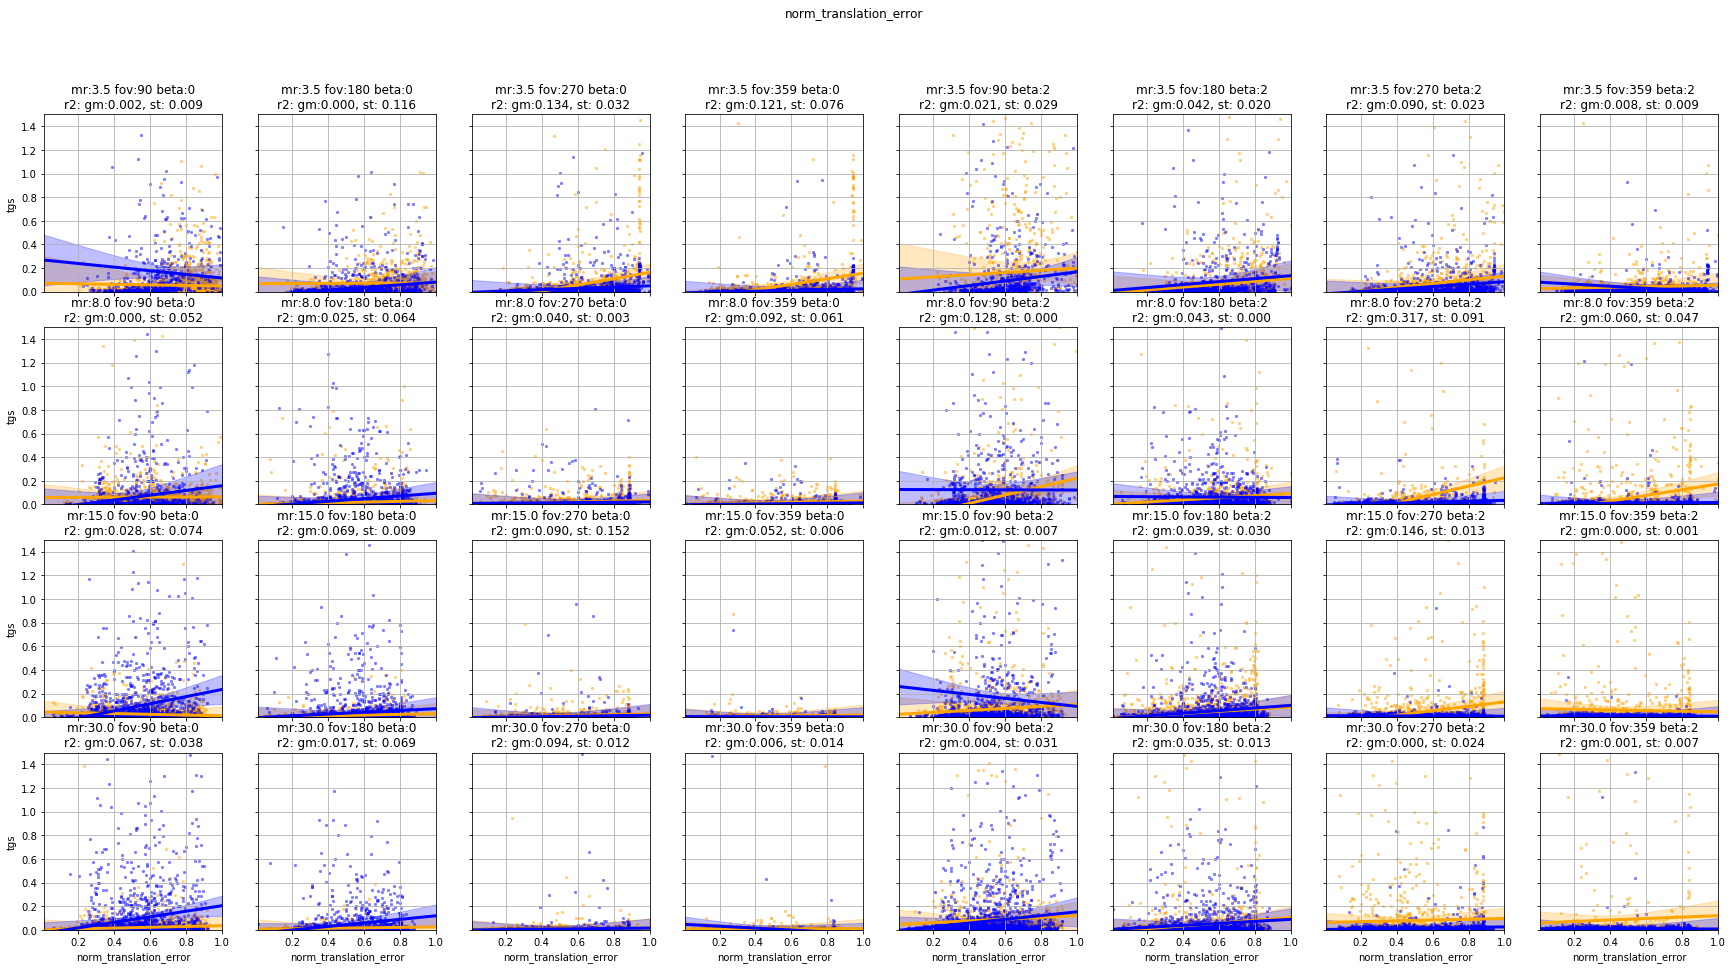

In [7]:

fig, axs = plt.subplots(len(mrs), len(betas_fovs), sharex='all', sharey='all')
fig.set_size_inches([8/4*15, 15])
axs[0, 0].set_xlim(df.tgs_cont.min(), df.tgs_cont.max())
axs[0, 0].set_ylim(0, 1.5)

tgs_ls = np.linspace(df.tgs_cont.min(), df.tgs_cont.max(), n)
X = tgs_ls.reshape(-1, 1)

for i, mr in enumerate(mrs):
    for j, (beta, fov) in enumerate(betas_fovs):
        for slam_node in df.slam_node.unique():
            if (mr, fov, beta) in model[slam_node]:
                y_predict, y_std  = model[slam_node][(mr, fov, beta)].predict(X, return_std=True)
                axs[i, j].plot(tgs_ls, y_predict, linewidth=3, color=slam_node_colors[slam_node], label=f"{slam_node}, pred")
                axs[i, j].fill_between(tgs_ls, y_predict-y_std, y_predict+y_std, color=slam_node_colors[slam_node], alpha=0.25, label=f"{slam_node}, pred std")

                df_plot = df[(df.slam_node == slam_node) & 
                             (df.laser_scan_max_range == mr) & 
                             (df.laser_scan_fov_deg == fov) & 
                             (df.beta == beta)
                            ].groupby(df.tgs_cont)[output_metric.name].mean()
                axs[i, j].scatter(df_plot.index, df_plot, marker='x', s=5, color=slam_node_colors[slam_node], label=f"{slam_node}, data", alpha=0.5)
        
        if (mr, fov, beta) in model[slam_node]:
            r2_gm = float(model_r2[(model_r2.laser_scan_max_range == mr) & (model_r2.laser_scan_fov_deg == fov) & (model_r2.beta == beta) & (model_r2.slam_node == "gmapping")]["r2"])
            r2_st = float(model_r2[(model_r2.laser_scan_max_range == mr) & (model_r2.laser_scan_fov_deg == fov) & (model_r2.beta == beta) & (model_r2.slam_node == "slam_toolbox")]["r2"])
            axs[i, j].set_title(f"mr:{mr} fov:{fov} beta:{int(beta)}\nr2: gm:{r2_gm:0.3f}, st: {r2_st:0.3f}")
        else:
            axs[i, j].set_title(f"mr:{mr} fov:{fov} beta:{int(beta)}")

        axs[i, j].set(xlabel=output_metric.name, ylabel='tgs')
        axs[i, j].label_outer()
        axs[i, j].grid(True)

plt.grid(True)
plt.suptitle(f"{output_metric.name}")
plt.show()

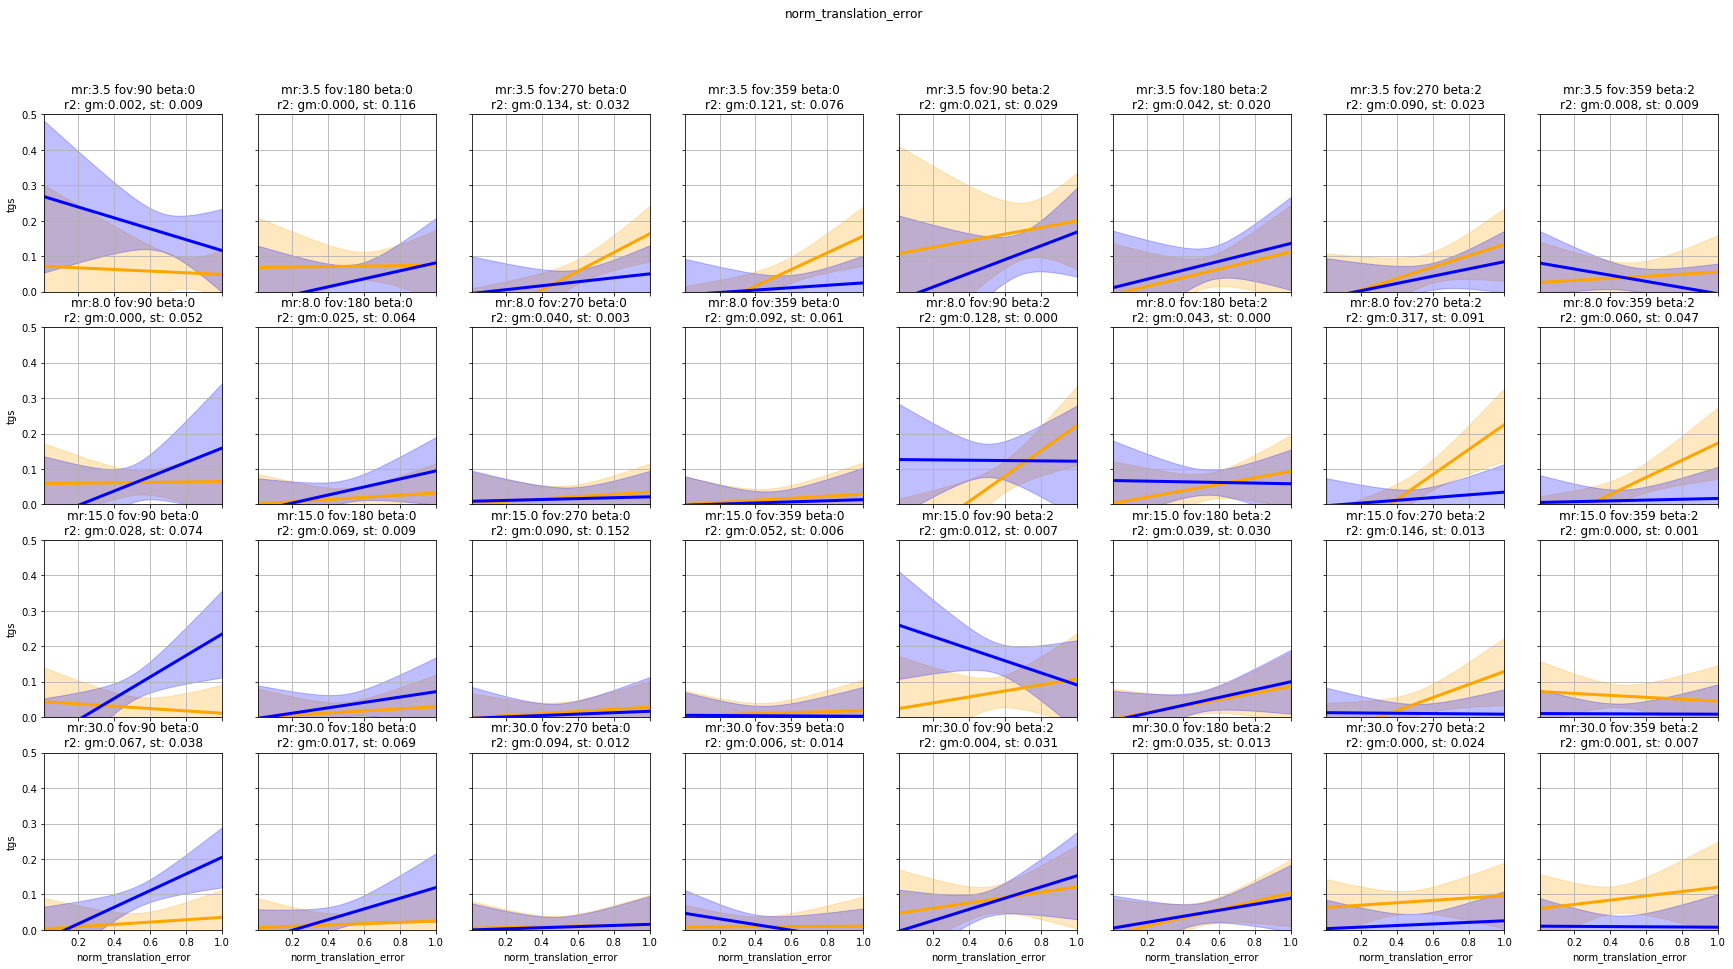

In [8]:

fig, axs = plt.subplots(len(mrs), len(betas_fovs), sharex='all', sharey='all')
fig.set_size_inches([8/4*15, 15])
axs[0, 0].set_xlim(df.tgs_cont.min(), df.tgs_cont.max())
axs[0, 0].set_ylim(0, .5)

tgs_ls = np.linspace(df.tgs_cont.min(), df.tgs_cont.max(), n)
X = tgs_ls.reshape(-1, 1)

for i, mr in enumerate(mrs):
    for j, (beta, fov) in enumerate(betas_fovs):
        for slam_node in df.slam_node.unique():
            if (mr, fov, beta) in model[slam_node]:
                y_predict, y_std = model[slam_node][(mr, fov, beta)].predict(X, return_std=True)
                axs[i, j].plot(tgs_ls, y_predict, linewidth=3, color=slam_node_colors[slam_node], label=f"{slam_node}, pred")
                axs[i, j].fill_between(tgs_ls, y_predict-y_std, y_predict+y_std, color=slam_node_colors[slam_node], alpha=0.25, label=f"{slam_node}, pred std")
        
        if (mr, fov, beta) in model[slam_node]:
            r2_gm = float(model_r2[(model_r2.laser_scan_max_range == mr) & (model_r2.laser_scan_fov_deg == fov) & (model_r2.beta == beta) & (model_r2.slam_node == "gmapping")]["r2"])
            r2_st = float(model_r2[(model_r2.laser_scan_max_range == mr) & (model_r2.laser_scan_fov_deg == fov) & (model_r2.beta == beta) & (model_r2.slam_node == "slam_toolbox")]["r2"])
            axs[i, j].set_title(f"mr:{mr} fov:{fov} beta:{int(beta)}\nr2: gm:{r2_gm:0.3f}, st: {r2_st:0.3f}")
        else:
            axs[i, j].set_title(f"mr:{mr} fov:{fov} beta:{int(beta)}")

        axs[i, j].set(xlabel=output_metric.name, ylabel='tgs')
        axs[i, j].label_outer()
        axs[i, j].grid(True)

plt.grid(True)
plt.suptitle(f"{output_metric.name}")
plt.show()

11228    7A-2
11235    7A-2
11240    7A-2
11597    7A-2
11603    7A-2
11610    7A-2
11644    7A-2
11647    7A-2
11648    7A-2
11651    7A-2
11654    7A-2
11657    7A-2
13364    7A-2
13367    7A-2
13372    7A-2
13376    7A-2
13383    7A-2
15428    7A-2
15433    7A-2
16792    7A-2
16795    7A-2
16807    7A-2
16881    7A-2
16884    7A-2
16889    7A-2
16893    7A-2
16950    7A-2
16955    7A-2
Name: environment_name, dtype: object


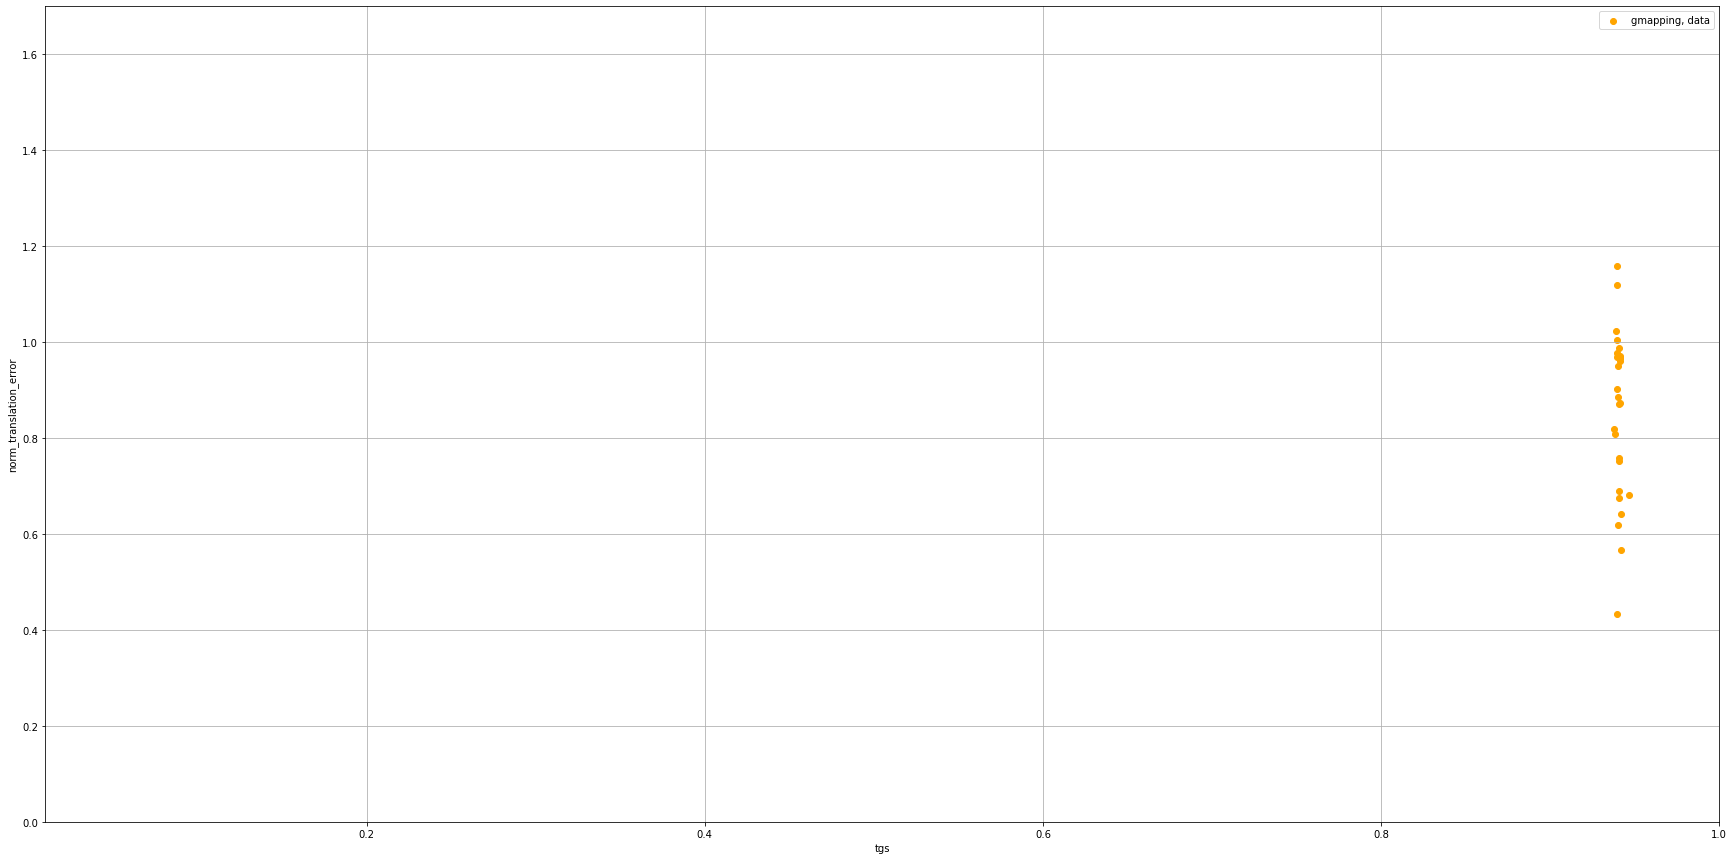

laser_scan_max_range: 3.5 laser_scan_fov_deg: 359 beta: 0
       slam_node        r2
3       gmapping  0.120730
35  slam_toolbox  0.076161


In [9]:
df_s = df[
    (df.slam_node == "gmapping") & 
    (df.laser_scan_max_range == 3.5) & 
    (df.laser_scan_fov_deg == 359) & 
    (df.beta == 0) &
    (df.tgs_cont > 0.9) &
    (df.tgs_cont < 0.95) &
    (df.norm_translation_error > 0.4)
]
print(df_s.environment_name)

slam_node, laser_scan_max_range, laser_scan_fov_deg, beta = "gmapping", 3.5, 359, 0

plt.figure(figsize=1.5*np.array([20, 10]))

tgs_ls = np.linspace(df_s.tgs_cont.min(), df_s.tgs_cont.max(), n)
X = tgs_ls.reshape(-1, 1)

df_plot = df_s.groupby(df_s.tgs_cont)[output_metric.name].mean()
plt.scatter(df_plot.index, df_plot, marker='o', color=slam_node_colors[slam_node], label=f"{slam_node}, data")
plt.legend()
plt.xlim([df.tgs_cont.min(), df.tgs_cont.max()])
plt.ylim([0.0, 1.7])
plt.xlabel("tgs")
plt.ylabel(f"{output_metric.name}")
plt.grid()
plt.show()
print("laser_scan_max_range:", laser_scan_max_range, "laser_scan_fov_deg:", laser_scan_fov_deg, "beta:", beta)
print(model_r2[(model_r2.laser_scan_max_range == laser_scan_max_range) & (model_r2.laser_scan_fov_deg == laser_scan_fov_deg) & (model_r2.beta == beta)][["slam_node", "r2"]])
